# Lab4 Intro
Now that you have classified the Voice of Customers into categories in the previous experiment, you can use Generative AI techniques to write analysis report for you further.

### Your objectives are:

- Explore the statistical results of classification
- Write a summary analysis report
- Tuning the prompt instruction to enhance the report

## 1. Install dependencies
- If you experince "ERROR: pip's dependency resolver does not currently...", please just ignore it

In [1]:
!pip install -Uq boto3 langchain==0.2.16 langchain_aws==0.1.17 pandas==2.2.2 openpyxl==3.1.5 termcolor==2.4.0

## 2. Initialize Bedrock model using LangChain

We will continue to use Amazon Foundation Model to help generate analysis for the result. 
- We use [Langchain](https://www.langchain.com/) SDK to build the application
- Initialize a ChatBedrock object with Amzon Foundation model, the model id is <span style="color: blue;">"amazon.olympus-pro-v1:0"</span>

#### Customzie a LangChain ChatModel Class
- As the time of this event, LangChain has not supported the latest Amazon Foundation Model yet, we will customize a LangChain Chat Model Class, so that the latest model can be integrated with the chain prompting in LangChain.

In [2]:
import boto3
import json
from botocore.exceptions import ClientError
import dotenv
import os
dotenv.load_dotenv()

from typing import Any, AsyncIterator, Dict, Iterator, List, Optional

from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import BaseChatModel, SimpleChatModel
from langchain_core.messages import AIMessageChunk, BaseMessage, HumanMessage,AIMessage,SystemMessage
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.runnables import run_in_executor
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain_core.output_parsers import StrOutputParser,XMLOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder,HumanMessagePromptTemplate


class ChatModelOly(BaseChatModel):

    model_name: str
    br_runtime : Any = None
    ak: str = None
    sk: str = None
    region:str = None

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:

        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
            
                                              )

            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.5)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}


        # Send the message.
        response = self.br_runtime.converse(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        output_message = response['output']['message']

        message = AIMessage(
            content=output_message['content'][0]['text'],
            additional_kwargs={},  # Used to add additional payload (e.g., function calling request)
            response_metadata={  # Use for response metadata
                **response['usage']
            },
        )
        generation = ChatGeneration(message=message)
        return ChatResult(generations=[generation])


    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        if not self.br_runtime:
            if self.ak and self.sk:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime',
                                               region_name = self.region,
                                              aws_access_key_id = self.ak,
                                               aws_secret_access_key = self.sk
                                                          )

            else:
                self.br_runtime = boto3.client(service_name = 'bedrock-runtime')
            
        
        new_messages = []
        system_message = ''
        for msg in messages:
            if isinstance(msg,SystemMessage):
                system_message = msg.content
            elif isinstance(msg,HumanMessage):
                new_messages.append({
                        "role": "user",
                        "content": [ {"text": msg.content}]
                    })
            elif isinstance(msg,AIMessage):
                new_messages.append({
                        "role": "assistant",
                        "content": [ {"text": msg.content}]
                    })

        
        temperature = kwargs.get('temperature',0.5)
        maxTokens = kwargs.get('max_tokens',3000)

        #Base inference parameters to use.
        inference_config = {"temperature": temperature,"maxTokens":maxTokens}

        # Send the message.
        streaming_response = self.br_runtime.converse_stream(
            modelId=self.model_name,
            messages=new_messages,
            system=[{"text" : system_message}] if system_message else [],
            inferenceConfig=inference_config
        )
        # Extract and print the streamed response text in real-time.
        for event in streaming_response["stream"]:
            if "contentBlockDelta" in event:
                text = event["contentBlockDelta"]["delta"]["text"]
                # print(text, end="")
                chunk = ChatGenerationChunk(message=AIMessageChunk(content=[{"type":"text","text":text}]))

                if run_manager:
                    # This is optional in newer versions of LangChain
                    # The on_llm_new_token will be called automatically
                    run_manager.on_llm_new_token(token, chunk=chunk)

                yield chunk
            if 'metadata' in event:
                metadata = event['metadata']
                # Let's add some other information (e.g., response metadata)
                chunk = ChatGenerationChunk(
                    message=AIMessageChunk(content=[], response_metadata={**metadata})
                )
                if run_manager:

                    run_manager.on_llm_new_token(token, chunk=chunk)
                yield chunk

    @property
    def _llm_type(self) -> str:
        """Get the type of language model used by this chat model."""
        return "echoing-chat-model-advanced"

    @property
    def _identifying_params(self) -> Dict[str, Any]:
        """Return a dictionary of identifying parameters.

        This information is used by the LangChain callback system, which
        is used for tracing purposes make it possible to monitor LLMs.
        """
        return {
            "model_name": self.model_name,
        }

llm = ChatModelOly(model_name="amazon.olympus-pro-v1:0")

- test run

In [3]:
messages = [
    ("human", "translate to french: I love programming."),
]

In [4]:
for chunk in llm.stream(messages):
    if chunk.content and chunk.content[0].get('type') == 'text':
        print(chunk.content[0]['text'],end='',flush=True)

Certainly! The translation of "I love programming." into French is:

"J'adore la programmation."

Here's a bit more context to help you understand the translation:

- "J'adore" is a common way to express a strong liking for something. It translates to "I love" in English, but it carries a slightly more enthusiastic connotation than the everyday use of "love." 
- "la programmation" is the French term for "programming." 

If you want to convey a slightly less enthusiastic but still positive sentiment, you could also say:

"J'aime la programmation."

- "J'aime" translates directly to "I like," but in French, it can also be used to mean "I love" in a less intense way.

Both phrases are correct, and the choice between them depends on how strongly you want to express your affection for programming.

## 3. Load the VOC classification results data

At the end of Lab 3, we saved the classified results data into result_lab_3.csv file. To begin our analysis, we first need to load this results data and review its contents.

- Load the classification result data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

Matplotlib is building the font cache; this may take a moment.


In [7]:
raw_data = pd.read_csv('result_lab_3.csv')

- Use columns 'id','summary','reason','predict_label' 

For analysis purpose, we only need data from column 'summary', 'reason', and 'predict_label'. Execute the code below to retrieve these columns data and rename the column 'predict_label' to 'category'.

In [8]:
results = raw_data[['summary','reason','predict_label']].rename(columns={'predict_label':'category'})
results

,summary,reason,category
0,"Phone lagging and freezing frequently, repair ...",The comment mentions the phone lagging and fre...,device freezing
1,Update process failed with device spinning and...,The comment describes a failed update process ...,update failure
2,"New phone has scratches, camera ghosting, redd...",The comment mentions multiple issues including...,poor manufacturing quality
3,"Phone randomly restarts or turns off, causing ...",The comment describes the phone randomly resta...,"automatic restart, shutdown"
4,Tablet update gets stuck on 'Verifying Update'...,The comment describes an issue with the update...,update failure
...,...,...,...
195,NaN,NaN,NaN
196,NaN,NaN,NaN
197,NaN,NaN,NaN
198,NaN,NaN,NaN


## 4. A simple summary report

We have defined a simple system prompt and user prompt to instruct Amazon Foundation model to generate a analysis report. The results data will be incorporated into the prompt as a variable, allowing the model to access and utilize this information in its report generation.

### 4.1 Define system prompt and user prompt template

In [9]:
user = """
You are a data analysis expert in the retail industry. 
Your task is to analyze the given data and write a narrative summary analysis report.
Follow these instructions:

<instructions>
- Transform the data into natural language, including all key data points as much as possible
- Only provide the final narrative report, do not show any intermediate analysis steps or processes
- Give insights and interpretations about the data in your narrative
</instructions>

Here is the tabular data in json to analyze:
<data>
{tabular}
</data>

Please summarize the data in a narrative report format, following the instructions above.
"""

- Create a langchain chat template

In [10]:
prompt_simple = ChatPromptTemplate([
    ('user',user),
    ])
chain = prompt_simple | llm | StrOutputParser()

### 4.2 Generate the report
- convert the tabular data to json string and pass them to llm

In [11]:
response = ''
for chunk in chain.stream({"tabular":results.to_json()}):
    print(colored(chunk,"green"),end='',flush=True)
    response += chunk

### Narrative Summary Analysis Report

The analyzed data reveals a variety of issues and concerns reported by users regarding their smartphones and other electronic devices. Here is a comprehensive summary of the key findings:

#### **Common Issues Identified:**
1. **Overheating:**
   - Multiple users reported their devices, especially new smartphone models, overheating. This issue is not only uncomfortable but also raises concerns about device safety and longevity.

2. **Automatic Restarts and Shutdowns:**
   - A significant number of comments highlighted problems with devices randomly restarting or shutting down. This instability causes frustration and often results in data loss or the need for re-setup.

3. **Screen and Camera Problems:**
   - Users frequently mentioned issues with screen color deviations, flickering, and unresponsiveness. Similarly, camera problems were prevalent, including color deviations, blurriness, and the camera failing to start or displaying a black screen.


## 5. Advanced version of report

The example provided above is a basic demonstration of the analysis generation capabilities of a LLM (Large Language Model). Now let's craft the prompt to generate a more comprehensize, concise, and detailed version of report.

The prompt provided below are much more detailed and contains steps-by-steps instruction and clear structure that can guide the LLM to generate a report rich in information. Additionally, we have supplied the LLM with statistical data, specifically the summary numbers of comments by category, to provide further context and enhance the depth of the analysis in the report.

- Add formation instruction and statistic data to enhance the report

- Let's stat the number of comments by categories

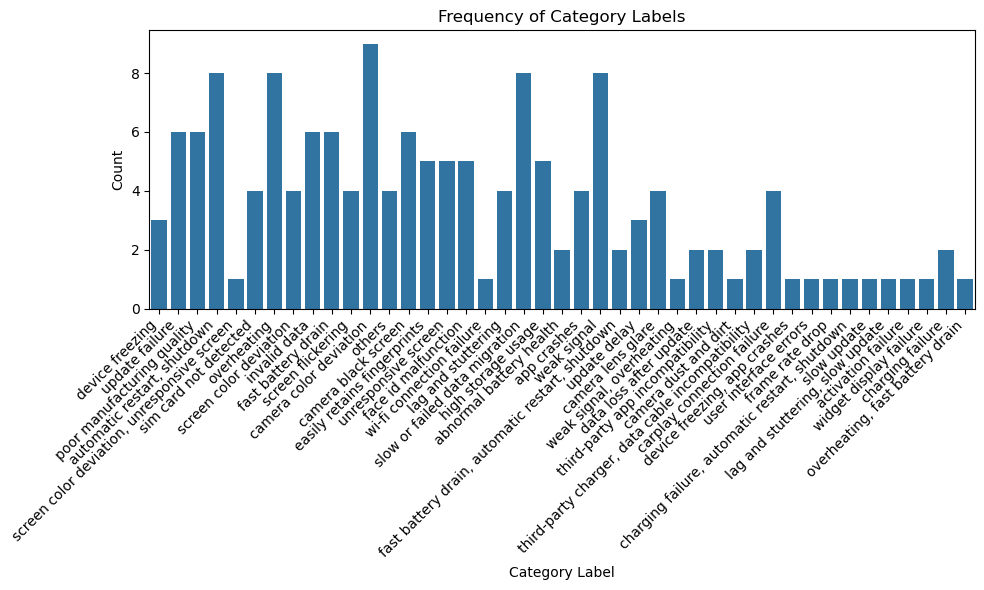

,summary
category,
abnormal battery health,2
activation failure,1
app crashes,4
"automatic restart, shutdown",8
camera black screen,6
camera color deviation,9
camera dust and dirt,1
camera lens glare,4
carplay connection failure,4


In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=results[['category']])
plt.title('Frequency of Category Labels')
plt.xlabel('Category Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

statistic_label = results.pivot_table(index='category',aggfunc='count')
statistic_label[['summary']]

### 5.1 Define system prompt and user prompt template
- we add instruction to generate report in certain content agenda as:
```markdown
# Executive Summary
Provide a brief overview of the report, summarizing key findings, conclusions, and recommendations. This section should be concise, allowing readers to grasp the main points quickly.

# Data Presentation
Data Overview: Provide a summary of the datasets used, including key metrics and attributes.
Key Performance Indicators (KPIs): Highlight the KPIs that are critical to the analysis.

# Findings
Present the results of the analysis in a structured manner:
Descriptive Statistics: Summarize the main characteristics of the data.
Trends and Patterns: Discuss any significant trends or patterns identified.
Comparative Analysis: If applicable, compare different datasets or time periods.

# Discussion
Interpret the findings in the context of the initial questions posed in the introduction.
Discuss the implications of the results, including potential impacts on business strategies or operations.
Address any unexpected results or anomalies.

# Conclusions
Summarize the key insights derived from the analysis.
Restate the significance of the findings in relation to the report’s objectives.

# Recommendations
Provide actionable recommendations based on the findings. These should be specific and feasible, guiding stakeholders on the next steps.
```

- And add additional context of statistic data in json


In [13]:
user = """
You are a data analysis expert in the retail industry
Your task is to analyze the given data and write a data analysis report. Follow these instructions:

- instructions:
- Transform the data into natural language, including all key data points as much as possible
- Only provide the final narrative report, do not show any intermediate analysis steps or processes
- Give insights and interpretations about the data in your narrative|
- the report should follow the content agenda as below:

# Executive Summary
Provide a brief overview of the report, summarizing key findings, conclusions, and recommendations. 
This section should be concise, no more than 100 words.

# Data Presentation
Data Overview: Provide a summary of the datasets used, including key metrics and attributes.
Key Performance Indicators (KPIs): Highlight the KPIs that are critical to the analysis.

# Findings
Present the results of the analysis in a structured manner:
Descriptive Statistics: Summarize the main characteristics of the data.
Trends and Patterns: Discuss any significant trends or patterns identified.
Comparative Analysis: If applicable, compare different datasets or time periods.

# Discussion
Interpret the findings in the context of the initial questions posed in the introduction.
Discuss the implications of the results, including potential impacts on business strategies or operations.
Address any unexpected results or anomalies.

# Conclusions
Summarize the key insights derived from the analysis.
Restate the significance of the findings in relation to the report’s objectives.

# Recommendations
Provide actionable recommendations based on the findings. These should be specific and feasible, guiding stakeholders on the next steps.


Here is the tabular data in json to analyze:
{tabular}

Here are the statistic data in json:
{statistic}

Please generate the report in markdown format:
"""

- Create a langchain chat template

In [14]:
prompt_advanced_1 = ChatPromptTemplate([
    ('user',user),
    ])
chain_advanced = prompt_advanced_1 | llm | StrOutputParser()

- convert the tabular data and statistic to json string and pass them to llm

In [15]:
response_advanced = ''
for chunk in chain_advanced.stream({"tabular":results.to_json(),
                          'statistic':statistic_label['summary'].to_json()}):
    print(colored(chunk,"green"),end='',flush=True)
    response_advanced += chunk

# Executive Summary
This report analyzes user feedback and statistical data on various smartphone issues. Key findings highlight prevalent problems such as overheating, automatic restarts, and camera malfunctions. Recommendations include improving manufacturing quality, optimizing software updates, and enhancing customer support to address these issues effectively.

# Data Presentation
## Data Overview
The datasets encompass user comments and statistical data on smartphone issues. Key metrics include frequencies of specific problems like overheating, automatic restarts, and camera deviations.

## Key Performance Indicators (KPIs)
- Frequency of overheating reports
- Instances of automatic restarts and shutdowns
- Number of camera-related issues
- Occurrences of fast battery drain
- Reports of poor manufacturing quality

# Findings
## Descriptive Statistics
- Overheating is a significant issue, reported 8 times.
- Automatic restarts and shutdowns were reported 8 times.
- Camera-related 

### 5.2 Display the report in markdown

In [16]:
from IPython.display import Markdown, display,HTML
display(Markdown(response_advanced))

# Executive Summary
This report analyzes user feedback and statistical data on various smartphone issues. Key findings highlight prevalent problems such as overheating, automatic restarts, and camera malfunctions. Recommendations include improving manufacturing quality, optimizing software updates, and enhancing customer support to address these issues effectively.

# Data Presentation
## Data Overview
The datasets encompass user comments and statistical data on smartphone issues. Key metrics include frequencies of specific problems like overheating, automatic restarts, and camera deviations.

## Key Performance Indicators (KPIs)
- Frequency of overheating reports
- Instances of automatic restarts and shutdowns
- Number of camera-related issues
- Occurrences of fast battery drain
- Reports of poor manufacturing quality

# Findings
## Descriptive Statistics
- Overheating is a significant issue, reported 8 times.
- Automatic restarts and shutdowns were reported 8 times.
- Camera-related issues, including color deviations and black screens, were reported 9 and 6 times, respectively.
- Fast battery drain was reported 6 times.
- Poor manufacturing quality was noted 6 times.

## Trends and Patterns
- A notable trend is the high frequency of overheating and automatic restarts, indicating potential hardware or software inefficiencies.
- Camera issues, such as color deviations and black screens, are consistently reported, suggesting a need for improved camera technology and software integration.
- Fast battery drain is a recurring problem, often accompanied by automatic restarts, pointing to possible battery management issues.

## Comparative Analysis
Comparing different datasets reveals that overheating and automatic restarts are more frequently reported than other issues like weak signal or app crashes. This suggests a priority area for improvement in device stability and performance.

# Discussion
The findings indicate that users are significantly impacted by overheating, automatic restarts, and camera issues. These problems not only affect user experience but also suggest underlying manufacturing and software integration challenges. The high frequency of these issues implies a need for immediate attention and resolution.

# Conclusions
The analysis underscores the critical need to address overheating, automatic restarts, and camera malfunctions. These issues are not only frequent but also severely impact user satisfaction and device reliability.

# Recommendations
1. **Enhance Manufacturing Quality**: Implement stricter quality control measures to reduce instances of poor manufacturing.
2. **Optimize Software Updates**: Ensure updates are thoroughly tested to prevent automatic restarts and fast battery drain.
3. **Improve Camera Technology**: Invest in better camera sensors and software to eliminate color deviations and black screens.
4. **Strengthen Customer Support**: Provide timely and effective support for users experiencing these issues to improve overall satisfaction.
5. **Conduct Further Research**: Investigate the root causes of overheating and automatic restarts to develop long-term solutions.